In [2]:
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import scipy
from sklearn.manifold import TSNE
import pandas as pd
from codes.base import *
from codes.plot import *

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Preprocessing

In [3]:
input_ = 'GSE104775_RLD_OurDEG_ADWT_bM100_augmentation_rev.npz'
rlds, ages, types, glists, genders, regions = load_dataset(input_)
print (rlds.shape, np.min(rlds), np.max(rlds))

(846, 1208) 5.644508 17.103043


(846, 1208) -0.6046131964467976 2.22547318616006


[]

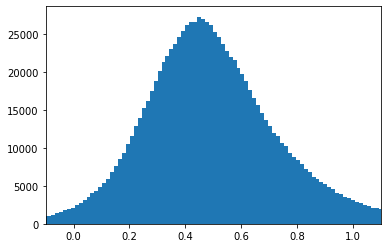

In [4]:
# cond_list=[aug_AD_2M, aug_AD_4M, aug_AD_7M, aug_WT_2M, aug_WT_4M, aug_WT_7M]
# org_clist=[AD_2M, AD_4M, AD_7M, WT_2M, WT_4M, WT_7M]
rescaled_rld, cond_list, org_clist = rescaling(rlds)
print (rescaled_rld.shape, np.min(rescaled_rld), np.max(rescaled_rld))

plt.figure()
plt.hist(rescaled_rld.flatten(), bins=200)
plt.xlim(-0.1, 1.1)
plt.plot()

In [ ]:
plot_scatter_cond(rescaled_rld, org_clist[2])
plot_scatter_cond(rescaled_rld, org_clist[2], org_clist[5])

In [6]:
rld = rescaled_rld
nrld = rld.flatten()
te_ratio = 0.1

#split training and test dataset
x_idx = np.arange(len(rld))
te_idx = np.random.choice(len(rld), int(len(rld)*te_ratio), False)
tr_idx = np.setdiff1d(x_idx, te_idx)
xtr, xte = rld[tr_idx], rld[te_idx]
tr_max = np.max(xtr)
n_tr, n_te = len(xtr), len(xte)

print ('xtr:', xtr.shape, ',xte:', xte.shape)
n, p = xtr.shape

xtr: (762, 1208) ,xte: (84, 1208)


## Training 

In [7]:
#hyperparameters
lr = 1e-5
epochs, batch = 200000, 32
z_dim = 100

gen_size, disc_size = 250, 150

In [8]:
#custom function
def get_noise(batch_size):
    return nrld[np.random.randint(0,len(nrld),size=(batch_size, z_dim))]

def get_batch(batch_size):
    idx_ = np.random.choice(n_tr, batch_size, replace=False)
    return xtr[idx_]

In [9]:
#variables
x = tf.placeholder(tf.float32, shape=(None, p))
z = tf.placeholder(tf.float32, shape=(None, z_dim))

In [10]:
gen_init=0.3
def generator(z, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        gen_dense1 = tf.layers.dense(inputs=z, units=gen_size, kernel_initializer=tf.random_uniform_initializer(-gen_init,gen_init), activation=tf.nn.leaky_relu, name='gen_dense1')
        gen_dense2 = tf.layers.dense(inputs=gen_dense1, units=gen_size, kernel_initializer=tf.random_uniform_initializer(-gen_init,gen_init), activation=tf.nn.leaky_relu, name='gen_dense2')
        gen_logit = tf.layers.dense(inputs=gen_dense2, units=p, kernel_initializer=tf.random_uniform_initializer(-gen_init,gen_init), activation=None, name='gen_logit')
        return gen_logit
    
def discriminator(x, type_=0, reuse=False): #type0:logit, type1:weight
    with tf.variable_scope('discriminator', reuse=reuse):
        disc_dense1 = tf.layers.dense(inputs=x, units=disc_size, activation=tf.nn.leaky_relu, name='disc_dense1')
        disc_dense2 = tf.layers.dense(inputs=disc_dense1, units=disc_size, activation=tf.nn.leaky_relu, name='disc_dense2')
        disc_logit = tf.layers.dense(inputs=disc_dense2, units=1, activation=None, name='disc_logit')
        if type_==0: #return logit
            return disc_logit
        elif type_==1: #for weight calculation
            return disc_dense1, disc_dense2

In [11]:
G = generator(z)
print (G.shape)

D_real, D_fake = discriminator(x), discriminator(G, reuse=True)
print (D_real.shape, D_fake.shape)

dw1, dw2 = discriminator(x, 1, reuse=True)
print (dw1.shape, dw2.shape)

(?, 1208)
(?, 1) (?, 1)
(?, 150) (?, 150)


In [12]:
#WGAN-GP
lambda_ = 10
eps = tf.random_uniform([batch,1], minval=0, maxval=tr_max)
x_inter = eps*x + (1-eps)*G
grad = tf.gradients(discriminator(x_inter, reuse=True), [x_inter])[0]
dgrad = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=1))
gp = lambda_*tf.reduce_mean(tf.square(dgrad-1.))

obj_d = tf.reduce_mean(D_fake) - tf.reduce_mean(D_real) + gp
obj_g = -tf.reduce_mean(D_fake)

In [13]:
T_vars = tf.trainable_variables()
d_vars = [var for var in T_vars if var.name.startswith('discriminator')]
g_vars = [var for var in T_vars if var.name.startswith('generator')]

print ('* d_params')
print (d_vars)
print ()
print ('* g_params')
print (g_vars)

* d_params
[<tf.Variable 'discriminator/disc_dense1/kernel:0' shape=(1208, 150) dtype=float32_ref>, <tf.Variable 'discriminator/disc_dense1/bias:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'discriminator/disc_dense2/kernel:0' shape=(150, 150) dtype=float32_ref>, <tf.Variable 'discriminator/disc_dense2/bias:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'discriminator/disc_logit/kernel:0' shape=(150, 1) dtype=float32_ref>, <tf.Variable 'discriminator/disc_logit/bias:0' shape=(1,) dtype=float32_ref>]

* g_params
[<tf.Variable 'generator/gen_dense1/kernel:0' shape=(100, 250) dtype=float32_ref>, <tf.Variable 'generator/gen_dense1/bias:0' shape=(250,) dtype=float32_ref>, <tf.Variable 'generator/gen_dense2/kernel:0' shape=(250, 250) dtype=float32_ref>, <tf.Variable 'generator/gen_dense2/bias:0' shape=(250,) dtype=float32_ref>, <tf.Variable 'generator/gen_logit/kernel:0' shape=(250, 1208) dtype=float32_ref>, <tf.Variable 'generator/gen_logit/bias:0' shape=(1208,) dtype=float32_ref>]


In [14]:
#optimizer
opt_g = tf.train.AdamOptimizer(learning_rate=lr).minimize(obj_g, var_list=g_vars)
opt_d = tf.train.AdamOptimizer(learning_rate=lr).minimize(obj_d, var_list=d_vars)

In [15]:
sub_path = os.getcwd()+'/weights/GSE104775/'
if not os.path.exists(sub_path):
    os.mkdir(sub_path)
np.savez(sub_path+'idx.npz', tr_idx=tr_idx, te_idx=te_idx) #save idxinfo

In [16]:
sess = tf.InteractiveSession()
saver = tf.train.Saver(max_to_keep=epochs)
init = tf.global_variables_initializer().run()

In [17]:
gen_x = []
dloss, gloss = [], []

tmp_z = get_noise(n_te)
print (tmp_z.shape)

(84, 100)


In [18]:
#Training!
saver.save(sess, sub_path+'ep0.ckpt') #save init weight
for ep in range(epochs):
    save_name = sub_path+'ep'+str(ep+1)+'.ckpt'
    for it in range(n//batch):
        sess.run(opt_d, {x:get_batch(batch), z:get_noise(batch)})
        sess.run(opt_g, {x:get_batch(batch), z:get_noise(batch)})
    dl, gl = sess.run([obj_d, obj_g], {x:get_batch(batch), z:get_noise(batch)})
    dloss.append(dl)
    gloss.append(gl)

    if (ep+1)%500==0:
        print ('epochs:',ep+1, '; dloss:', dl, ',gloss:',gl)
        saver.save(sess, save_name)
        tmpx = sess.run(G, {z:tmp_z})
        gen_x.append(tmpx) #save fakex

epochs: 500 ; dloss: -2.6934972 ,gloss: 2.5043356
epochs: 1000 ; dloss: -1.2662129 ,gloss: -1.1454195
epochs: 1500 ; dloss: -0.741156 ,gloss: 2.1682024
epochs: 2000 ; dloss: -1.0389384 ,gloss: 2.3033097
epochs: 2500 ; dloss: -0.47292498 ,gloss: -3.465714
epochs: 3000 ; dloss: -1.2258576 ,gloss: 5.6932263
epochs: 3500 ; dloss: -0.40671897 ,gloss: -4.4723268
epochs: 4000 ; dloss: -4.8962774 ,gloss: 0.62925065
epochs: 4500 ; dloss: -3.5274832 ,gloss: 0.07608992
epochs: 5000 ; dloss: -2.582748 ,gloss: -5.1134043
epochs: 5500 ; dloss: -0.13755 ,gloss: -7.4747963
epochs: 6000 ; dloss: -6.7590795 ,gloss: 1.8811679
epochs: 6500 ; dloss: -4.901599 ,gloss: -0.5976541
epochs: 7000 ; dloss: -4.2813487 ,gloss: -5.9568605
epochs: 7500 ; dloss: -2.234857 ,gloss: -3.1432805
epochs: 8000 ; dloss: -2.8447676 ,gloss: 2.2699864
epochs: 8500 ; dloss: -2.5537982 ,gloss: 2.0616686
epochs: 9000 ; dloss: -2.3963113 ,gloss: 1.8523512
epochs: 9500 ; dloss: -1.7011999 ,gloss: 1.6463666
epochs: 10000 ; dloss: -1.7

epochs: 80500 ; dloss: -2.044628 ,gloss: 4.8593497
epochs: 81000 ; dloss: -1.780828 ,gloss: 5.208871
epochs: 81500 ; dloss: -1.9114856 ,gloss: 5.245097
epochs: 82000 ; dloss: -1.8554515 ,gloss: 5.1177325
epochs: 82500 ; dloss: -1.9779265 ,gloss: 5.2816725
epochs: 83000 ; dloss: -1.6572957 ,gloss: 4.816947
epochs: 83500 ; dloss: -1.9496236 ,gloss: 5.055245
epochs: 84000 ; dloss: -1.9468918 ,gloss: 4.9470205
epochs: 84500 ; dloss: -1.8318676 ,gloss: 5.082739
epochs: 85000 ; dloss: -2.284755 ,gloss: 5.173792
epochs: 85500 ; dloss: -2.0974836 ,gloss: 4.890542
epochs: 86000 ; dloss: -1.7135341 ,gloss: 4.9532356
epochs: 86500 ; dloss: -2.454643 ,gloss: 5.4098125
epochs: 87000 ; dloss: -1.8952677 ,gloss: 5.007476
epochs: 87500 ; dloss: -1.7961583 ,gloss: 5.104951
epochs: 88000 ; dloss: -1.8781761 ,gloss: 4.934438
epochs: 88500 ; dloss: -1.8080792 ,gloss: 4.976289
epochs: 89000 ; dloss: -1.5052484 ,gloss: 4.96747
epochs: 89500 ; dloss: -1.9916593 ,gloss: 5.308428
epochs: 90000 ; dloss: -1.9044

epochs: 159500 ; dloss: -1.4852625 ,gloss: 5.7555876
epochs: 160000 ; dloss: -1.245194 ,gloss: 5.4241085
epochs: 160500 ; dloss: -1.2016287 ,gloss: 5.276577
epochs: 161000 ; dloss: -1.1632854 ,gloss: 5.391923
epochs: 161500 ; dloss: -1.397203 ,gloss: 5.4346123
epochs: 162000 ; dloss: -1.1674806 ,gloss: 5.503463
epochs: 162500 ; dloss: -1.3566316 ,gloss: 5.491065
epochs: 163000 ; dloss: -1.5587108 ,gloss: 5.799954
epochs: 163500 ; dloss: -1.3896323 ,gloss: 5.46749
epochs: 164000 ; dloss: -1.6080911 ,gloss: 5.67698
epochs: 164500 ; dloss: -1.1325876 ,gloss: 5.5030117
epochs: 165000 ; dloss: -1.38514 ,gloss: 6.094738
epochs: 165500 ; dloss: -1.1953347 ,gloss: 5.4132967
epochs: 166000 ; dloss: -1.006151 ,gloss: 5.3278694
epochs: 166500 ; dloss: -0.9940784 ,gloss: 4.9795494
epochs: 167000 ; dloss: -1.3034785 ,gloss: 5.4438033
epochs: 167500 ; dloss: -1.1411183 ,gloss: 5.5442405
epochs: 168000 ; dloss: -1.7009751 ,gloss: 5.9300604
epochs: 168500 ; dloss: -1.6966919 ,gloss: 5.720705
epochs: 1

In [19]:
#save value
np.savez(sub_path+'training_results.npz', dloss=dloss, gloss=gloss, gen_x=gen_x)

## Training results

In [20]:
dat = np.load(sub_path+'training_results.npz')
dloss, gloss, gen_x = dat['dloss'], dat['gloss'], dat['gen_x']

[]

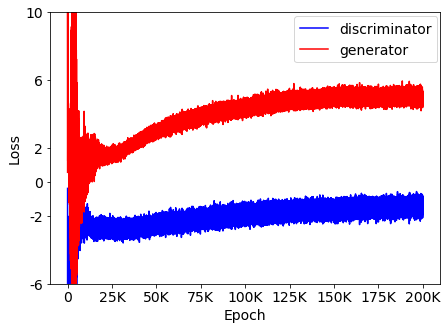

In [21]:
plt.figure(figsize=(7,5))
plt.plot(dloss, c='blue', label='discriminator')
plt.plot(gloss, c='red', label='generator')
plt.legend(loc=1, fontsize=14, bbox_to_anchor=(1.01,1.01))
plt.ylim(-6.0,10.0)
plt.yticks([-6,-2,0,2,6,10], ['-6', '-2', '0', '2', '6', '10'], fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(np.arange(0, 225000, 25000), ['0', '25K','50K','75K', '100K', '125K', '150K', '175K', '200K'], fontsize=14)
plt.plot()

In [22]:
gen_x = np.array(gen_x)
print (gen_x.shape)

BinN = int((np.max(rld.flatten())-np.min(rld.flatten()))/0.005)
print(BinN)

(400, 84, 1208)
566


In [23]:
#corr(fake_x, fake_x)
gen_gen_corr = np.zeros((gen_x.shape[0], gen_x.shape[1], gen_x.shape[1]))
for i in range(gen_gen_corr.shape[0]):
    for j in range(n_te):
        for k in range(n_te):
            tmp1, tmp2 = gen_x[i,j], gen_x[i,k]
            #print (tmp1.shape, tmp2.shape)
            gen_gen_corr[i,j,k] = scipy.stats.pearsonr(tmp1, tmp2)[0]
            
gen_gen_corr_flat = gen_gen_corr.reshape((len(gen_gen_corr), np.prod(gen_gen_corr.shape[1:])))
min_gen_gen = np.min(gen_gen_corr_flat, axis=1)
gen_gen_opt = np.argmin(min_gen_gen)
avg_gen_gen = np.average(gen_gen_corr_flat, axis=1)
avg_gen_opt = np.argmin(avg_gen_gen)

#corr(fake_x, real_xte)
gen_real_corr = np.zeros((gen_x.shape[0], gen_x.shape[1], gen_x.shape[1]))
for i in range(gen_real_corr.shape[0]):
    for j in range(n_te):
        for k in range(n_te):
            tmp1, tmp2 = gen_x[i,j], xte[k]
            gen_real_corr[i,j,k] = scipy.stats.pearsonr(tmp1, tmp2)[0]
gen_real_corr_flat = gen_real_corr.reshape((len(gen_real_corr), np.prod(gen_real_corr.shape[1:])))
max_gen_real = np.max(gen_real_corr_flat, axis=1)
gen_real_opt = np.argmax(max_gen_real)
avg_gen_real = np.average(gen_real_corr_flat, axis=1)
avg_real_opt = np.argmax(avg_gen_real)

#corr(real_x, real_x)
real_corr = np.zeros((rld.shape[0], rld.shape[0]))
for i in range(rld.shape[0]):
    for j in range(rld.shape[0]):
            tmp1, tmp2 = rld[i], rld[j]
            real_corr[i,j] = scipy.stats.pearsonr(tmp1, tmp2)[0]            

In [24]:
initx = np.concatenate((xtr, xte, gen_x[0]), axis=0)
med1x = np.concatenate((xtr, xte, gen_x[50]), axis=0) #25K
med2x = np.concatenate((xtr, xte, gen_x[100]), axis=0) #100K
endx = np.concatenate((xtr, xte, gen_x[-1]), axis=0)
print (initx.shape, med1x.shape, med2x.shape, endx.shape)

tsne = TSNE()
tsne_init = tsne.fit_transform(initx)
tsne_med1 = tsne.fit_transform(med1x)
tsne_med2 = tsne.fit_transform(med2x)
tsne_end = tsne.fit_transform(endx)
print (tsne_init.shape, tsne_med1.shape, tsne_med2.shape, tsne_end.shape)

(930, 1208) (930, 1208) (930, 1208) (930, 1208)
(930, 2) (930, 2) (930, 2) (930, 2)


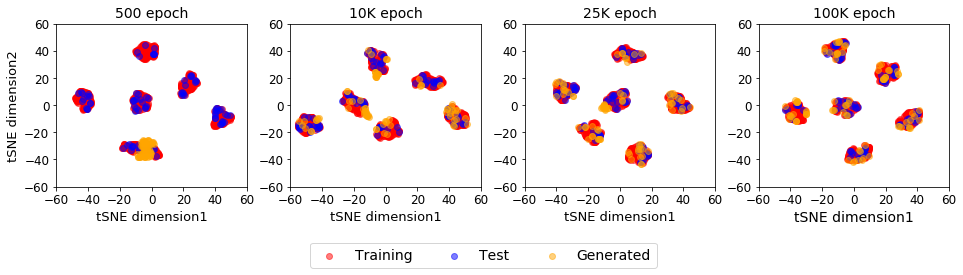

In [25]:
plot_tsne(tsne_init, tsne_med1, tsne_med2, tsne_end)

In [27]:
#restore saved weights
sname = sub_path+'ep100000.ckpt'
saver.restore(sess, sname)

INFO:tensorflow:Restoring parameters from /data/MKCheon/GAN_GE/GSE104775/weights/GSE104775/ep100000.ckpt


In [28]:
#generate augx for all samples
n_noise = 10000
tmpz = get_noise(n_noise)
tmp_genx = sess.run(G, {z:tmpz})
print (tmpz.shape, tmp_genx.shape)

genaugx = []
for i in range(len(rld)):
    tscorr = np.zeros((n_noise,))
    for j in range(n_noise):
        tscorr[j] = scipy.stats.pearsonr(rld[i], tmp_genx[j])[0]
    maxidx = np.argsort(tscorr)[-10:]
    avgz = np.average(tmpz[maxidx], axis=0)
    tgenx = sess.run(G, {z:avgz.reshape((1,100))})
    genaugx.append(tgenx)
genaugx = np.array(genaugx)
genaugx = genaugx.reshape((rld.shape))
print (genaugx.shape)

(10000, 100) (10000, 1208)
(846, 1208)


In [30]:
#Validate performance of network by comparing distribution of real and fake
##corr(real, fake)
aug_corr = np.zeros((rld.shape[0], rld.shape[0]))
for i in range(len(aug_corr)):
    for j in range(len(aug_corr)):
        tmp1, tmp2 = rld[i], genaugx[j]
        aug_corr[i,j] = scipy.stats.pearsonr(tmp1,tmp2)[0]

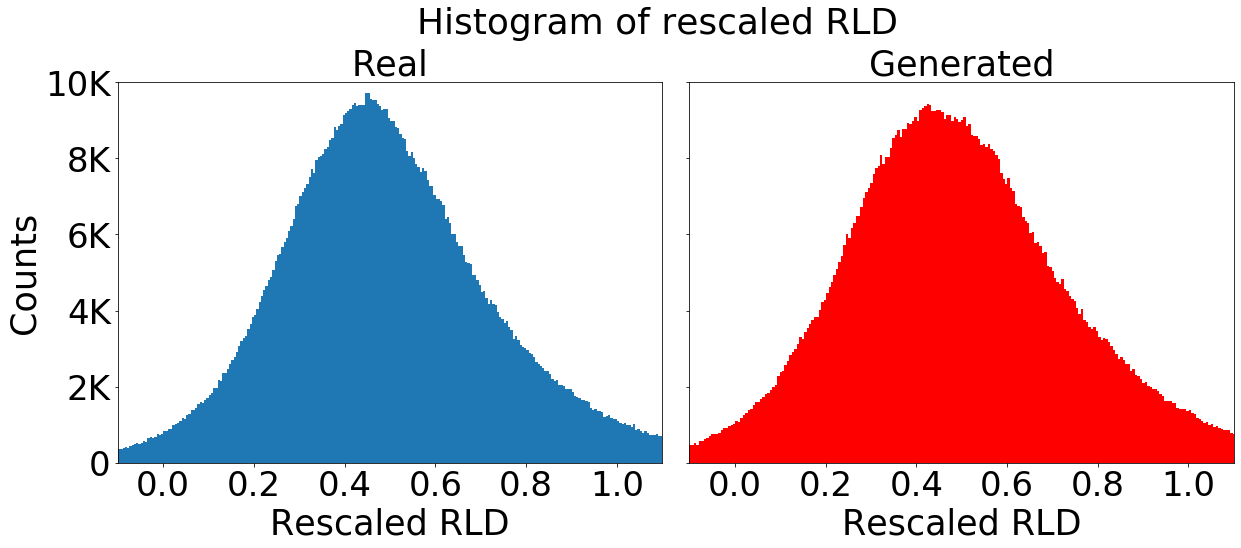

In [31]:
plot_hist_re_rld(rld, genaugx, BinN)

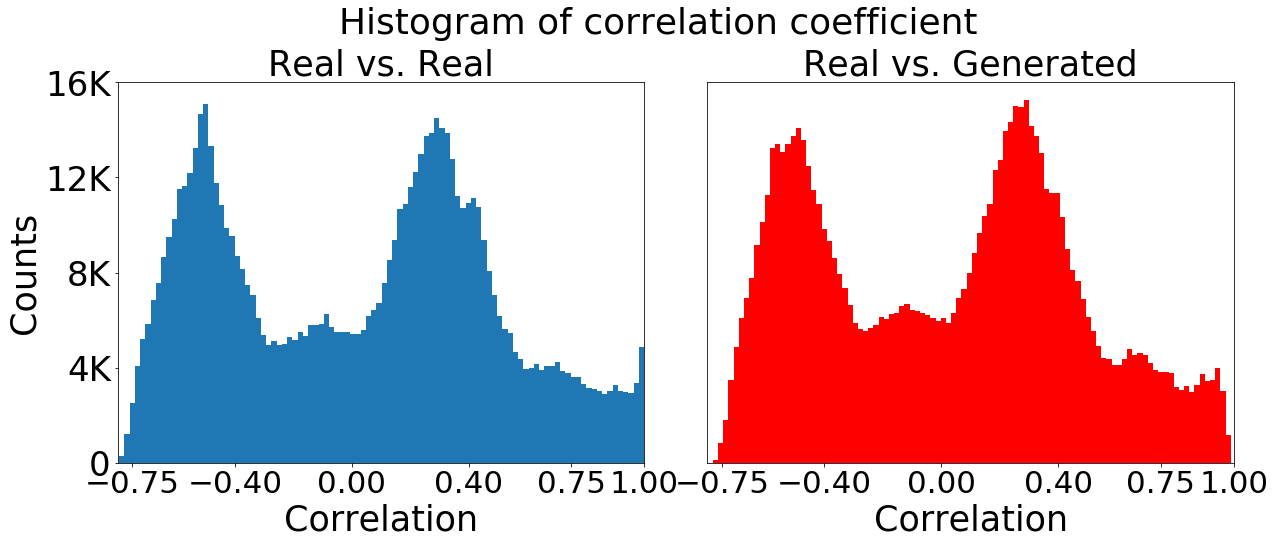

In [32]:
plot_hist_corr(real_corr, aug_corr)

## Analysis of training results

In [33]:
WTAD_inlist = [[cond_list[3], cond_list[0]],[cond_list[4], cond_list[1]],[cond_list[5], cond_list[2]]]
ep_ary = np.arange(0,50500,500)+75000

In [34]:
def latent_intpolation(sess, inlist, ep_ary):
    WTAD_z, WTAD_avgz, WTAD_genx, WTAD_gen_corr = [], [], [], []
    for ep in range(len(ep_ary)):
        #restore saved weights
        tep = 'ep'+str(ep_ary[ep])+'.ckpt'
        sname = sub_path+tep
        saver.restore(sess, sname)
        
        #get z from x
        n_noise = 10000
        gens, gene = [], []
        gen_scorr, gen_ecorr = [], []

        tmpz = get_noise(n_noise)
        tmp_genx = sess.run(G, {z:tmpz})
        for i in range(len(inlist)):
            s_, e_ = inlist[i][0], inlist[i][1]

            tmps, tmpe = [], []
            tmps_c, tmpe_c = [], []
            for s in range(len(s_)):
                scorr_ary, ecorr_ary = np.zeros((n_noise,)), np.zeros((n_noise,))
                for j in range(n_noise):
                    scorr_ary[j] = scipy.stats.pearsonr(rld[s_[s]], tmp_genx[j])[0]
                    ecorr_ary[j] = scipy.stats.pearsonr(rld[e_[s]], tmp_genx[j])[0]
                    #smaxidx, emaxidx = np.argmax(scorr_ary), np.argmax(ecorr_ary)
                smaxidx = np.argsort(scorr_ary)[-10:]
                emaxidx = np.argsort(ecorr_ary)[-10:]
                tmps.append(np.average(tmpz[smaxidx],axis=0))
                tmpe.append(np.average(tmpz[emaxidx],axis=0))
                tmps_c.append(np.average(scorr_ary[smaxidx]))
                tmpe_c.append(np.average(ecorr_ary[emaxidx]))
            gens.append(tmps)
            gene.append(tmpe)            
            gen_scorr.append(tmps_c)
            gen_ecorr.append(tmpe_c)

        gens, gene = np.array(gens), np.array(gene)
        gen_scorr, gen_ecorr = np.array(gen_scorr),np.array(gen_ecorr)
        delta_z = np.average(gene,axis=1)-np.average(gens,axis=1)
        inter_ = np.linspace(0., 1., num=101)

        WTAD_gen_corr.append([gen_scorr, gen_ecorr])
        WTAD_z.append([gens, gene])
        WTAD_avgz.append(delta_z)

        #generate fake by interpolating latent vector
        genx = []
        for ag in range(gens.shape[0]): #age
            tmpgenx = []
            for aug_sp in range(gens.shape[1]): #aug_samples
                ttmpgenx = []
                for z_ in inter_: #interpolate
                    tmpz = gens[ag][aug_sp] + (delta_z[ag]*z_)
                    tmpx = sess.run(G, {z:tmpz.reshape((1,100))})
                    ttmpgenx.append(tmpx)
                tmpgenx.append(ttmpgenx)
            genx.append(tmpgenx)
        genx = np.array(genx)
        genx = genx.reshape((len(delta_z), np.shape(gens)[1],len(inter_), p))

        WTAD_genx.append(genx)
    WTAD_z, WTAD_avgz = np.array(WTAD_z), np.array(WTAD_avgz)
    WTAD_genx, WTAD_gen_corr = np.array(WTAD_genx), np.array(WTAD_gen_corr)
    return WTAD_z, WTAD_avgz, WTAD_genx, WTAD_gen_corr

In [ ]:
WTAD_z, WTAD_avgz, WTAD_genx, WTAD_gen_corr = latent_intpolation(sess, WTAD_inlist, ep_ary)

In [36]:
#save value
np.savez(sub_path+'generated_from_75k_to_125k.npz', WTAD_z=WTAD_z, WTAD_avgz=WTAD_avgz, WTAD_genx=WTAD_genx, WTAD_gen_corr=WTAD_gen_corr) #genxAE_WTAD

In [37]:
"""
#z:(eps,types(WT2/4/7M,AD2/4/7M),#augsamples,zdim)
#avgz:(eps,ages(2/4/7M),zdim)
#genx:(eps,ages(2/4/7M),#augsamples,timesteps,p)
#gencorr:(eps,types(WT2/4/7M,AD2/4/7M),#augsamples)
"""
#load saved data
dat_ = np.load(sub_path+'generated_from_75k_to_125k.npz')
WTAD_z, WTAD_avgz, WTAD_genx, WTAD_gen_corr = dat_['WTAD_z'], dat_['WTAD_avgz'], dat_['WTAD_genx'], dat_['WTAD_gen_corr']
WTAD_z, WTAD_avgz, WTAD_genx, WTAD_gen_corr = data_flatten(WTAD_z, WTAD_avgz, WTAD_genx, WTAD_gen_corr)
print (WTAD_z.shape, WTAD_avgz.shape, WTAD_genx.shape, WTAD_gen_corr.shape)

#extract related to real values
WTAD_realz, WTAD_real_gcorr = ext_realv(WTAD_z, WTAD_gen_corr, org_clist)
print (WTAD_realz.shape, WTAD_real_gcorr.shape)

(101, 6, 141, 100) (101, 3, 100) (101, 3, 141, 101, 1208) (101, 6, 141)
(101, 36, 100) (101, 36)


In [38]:
#get generated_x at 100K #ep_ary[50]
genx_100K = sess.run(G, {z:WTAD_realz[50]})
gencorr_100K = WTAD_real_gcorr[50]
print (genx_100K.shape, gencorr_100K.shape)

(36, 1208) (36,)


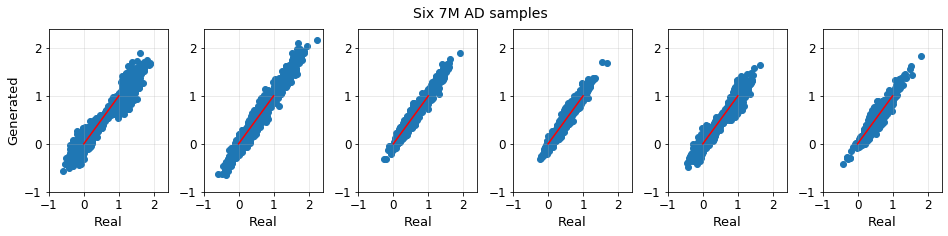

In [39]:
#(Val1) Compare real and genx
plot_comp_real_and_genx(rld, genx_100K, org_clist, 2)

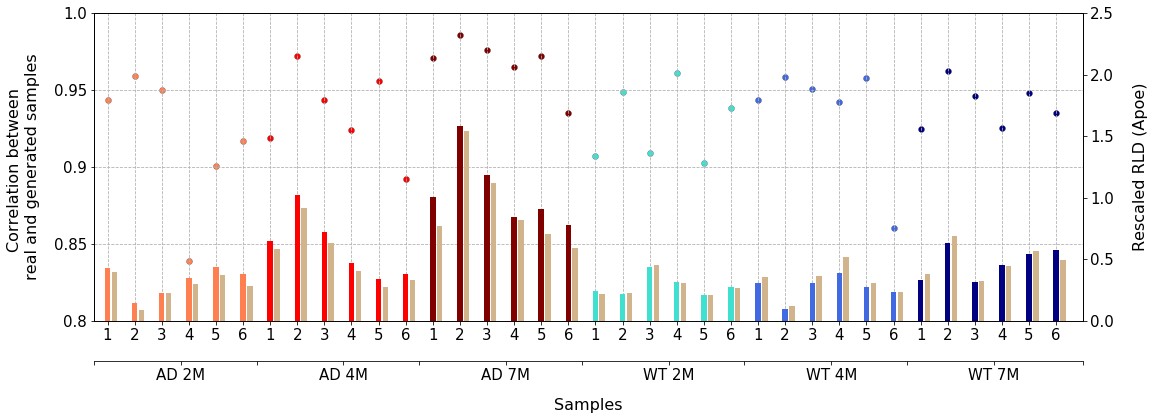

In [40]:
#(Val2) Compare within specific genes
plot_generated_kwd(rld, genx_100K, gencorr_100K, org_clist, glists, 'Apoe')

In [41]:
genx_A = np.average(np.average(WTAD_genx, axis=2), axis=0)
genx_S = np.std(np.average(WTAD_genx, axis=2), axis=0)
print (genx_A.shape, genx_S.shape)

(3, 101, 1208) (3, 101, 1208)


In [42]:
flist = [['Apoe', 'Abca1'], ['Kcnq3', 'Kcnq5']]

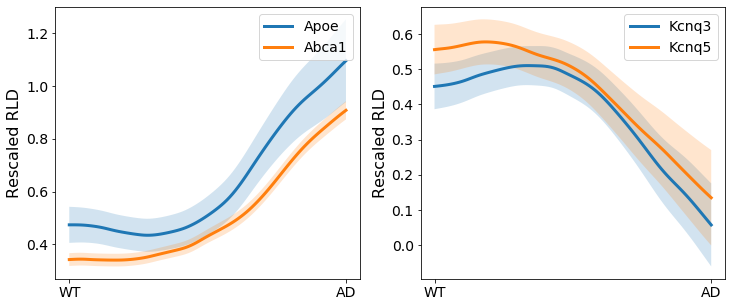

In [43]:
plot_transition_curves(genx_A, genx_S, glists, flist)